In [2]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from Bio import SeqIO
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, make_scorer
from statistics import stdev, variance, mean

In [3]:
random.seed(0)

In [4]:
species="Mus_musculus"

In [5]:
species_dict={"Mus_musculus":"mouse", "Saccharomyces_cerevisiae":"yeast", "Arabidopsis_thaliana":"arabi"}

In [6]:
client_set=set()
others_set=set()
for rec in SeqIO.parse("../fig1/result/drllps_client_clstr_Homo_sapiens.fasta", "fasta"):
    client_set.add(rec.id)
for rec in SeqIO.parse("../fig1/result/drllps_nonllps_clstr_Homo_sapiens.fasta", "fasta"):
    others_set.add(rec.id)
    
mat=np.load("../fig2/PTT5XLU50_human.npy", allow_pickle=True)
mat=mat.item()

list_client=[]
list_others=[]
for k in mat.keys():
    if k in others_set:
        list_others.append(mat[k])
    elif k in client_set:
        list_client.append(mat[k])

In [10]:
client_set=set()
others_set=set()
no_homolog_set=set()
for rec in SeqIO.parse("result/drllps_client_clstr_"+species+".fasta", "fasta"):
    client_set.add(rec.id)
for rec in SeqIO.parse("result/drllps_nonllps_clstr_"+species+".fasta", "fasta"):
    others_set.add(rec.id)
for rec in SeqIO.parse("result/"+species_dict[species]+"_no_human_homolog.faa", "fasta"):
    no_homolog_set.add(rec.id)
    
mat=np.load("data/PTT5XLU50_"+species_dict[species]+".npy", allow_pickle=True)
mat=mat.item()

list_client_mouse=[]
list_others_mouse=[]
for k in mat.keys():
    if k in others_set:
        if k in no_homolog_set:
            list_others_mouse.append(mat[k])
    elif k in client_set:
        if k in no_homolog_set:
            list_client_mouse.append(mat[k])

In [11]:
print(len(client_set),  len(others_set))

1382 12525


In [12]:
print(len(list_client_mouse),  len(list_others_mouse))

17 132


In [13]:
def under_sampling(client, others):
    positive_size=len(client)
    others=random.sample(others,positive_size)
    x=np.array(client+others)
    y=np.array([True]*len(client) + [False]*len(others))
    return x,y

In [14]:
print(len(under_sampling(list_client,list_others)[0]))
print(len(under_sampling(list_client_mouse,list_others_mouse)[0]))

5400
34


In [17]:
mean_fpr = np.linspace(0, 1, 1000)
tprs=[]
rocaucs=[]
praucs=[]
mccs=[]
for i in range(10):
    x_human, y_human=under_sampling(list_client,list_others)
    x_test, y_test=under_sampling(list_client_mouse, list_others_mouse)

    model=make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=True))
    model.fit(x_human,y_human)
    y_pred=model.predict_proba(x_test)[:,1]
    y_pred_bi=model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc=roc_auc_score(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    mcc=matthews_corrcoef(y_test, y_pred_bi)
    rocaucs.append(roc_auc)
    praucs.append(pr_auc)
    mccs.append(mcc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    print(i)
print("ROCAUC={}±{}, PRAUC={}±{}, MCC={}±{}".format(mean(rocaucs), stdev(rocaucs), mean(praucs), stdev(praucs), mean(mccs), stdev(mccs)))

0
1
2
3
4
5
6
7
8
9
ROCAUC=0.8238754325259515±0.06290962383734496, PRAUC=0.7972302953275399±0.10221857170771195, MCC=0.5117146687802056±0.1302405057307994


In [18]:
print("ROCAUC={:.3f}±{:.3f}, PRAUC={:.3f}±{:.3f}, MCC={:.3f}±{:.3f}".format(mean(rocaucs), stdev(rocaucs), mean(praucs), stdev(praucs), mean(mccs), stdev(mccs)))

ROCAUC=0.824±0.063, PRAUC=0.797±0.102, MCC=0.512±0.130


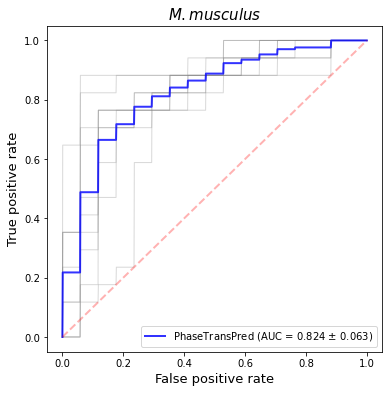

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fpr = np.linspace(0, 1, 1000)
for i, tpr in enumerate(tprs):
    ax.plot(
    fpr,
    tpr,
    color="gray",
    lw=1,
    alpha=0.3
    )
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc=mean(rocaucs)
std_auc=stdev(rocaucs)
ax.plot(
    fpr,
    mean_tpr,
    color="b",
    label=r"Seq2Phase (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.3)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Mouse",
)
ax.set_title("$\it{M. musculus}$",fontsize=15)
ax.legend(loc="lower right")
ax.set_xlabel("False positive rate", fontsize=13)
ax.set_ylabel("True positive rate", fontsize=13)
plt.savefig("fig5_M_musculus.pdf")
plt.show()

In [20]:
species="Arabidopsis_thaliana"

In [21]:
client_set=set()
others_set=set()
no_homolog_set=set()
for rec in SeqIO.parse("result/drllps_client_clstr_"+species+".fasta", "fasta"):
    client_set.add(rec.id)
for rec in SeqIO.parse("result/drllps_nonllps_clstr_"+species+".fasta", "fasta"):
    others_set.add(rec.id)
for rec in SeqIO.parse("result/"+species_dict[species]+"_no_human_homolog.faa", "fasta"):
    no_homolog_set.add(rec.id)
    
mat=np.load("data/PTT5XLU50_"+species_dict[species]+".npy", allow_pickle=True)
mat=mat.item()

list_client_arabi=[]
list_others_arabi=[]
for k in mat.keys():
    if k in others_set:
        if k in no_homolog_set:
            list_others_arabi.append(mat[k])
    elif k in client_set:
        if k in no_homolog_set:
            list_client_arabi.append(mat[k])

In [22]:
print(len(client_set),  len(others_set))

1149 8810


In [23]:
print(len(list_client),  len(list_others))
print(len(list_client_arabi),  len(list_others_arabi))

2700 12562
255 4571


In [24]:
print(len(under_sampling(list_client,list_others)[0]))
print(len(under_sampling(list_client_arabi,list_others_arabi)[0]))

5400
510


In [25]:
mean_fpr = np.linspace(0, 1, 1000)
tprs_2=[]
rocaucs_2=[]
praucs_2=[]
mccs_2=[]
for i in range(10):
    x_human, y_human=under_sampling(list_client,list_others)
    x_test, y_test=under_sampling(list_client_arabi,list_others_arabi)

    model=make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=True))
    model.fit(x_human, y_human)
    y_pred=model.predict_proba(x_test)[:,1]
    y_pred_bi=model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc=roc_auc_score(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    mcc=matthews_corrcoef(y_test, y_pred_bi)
    rocaucs_2.append(roc_auc)
    praucs_2.append(pr_auc)
    mccs_2.append(mcc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_2.append(interp_tpr)
    print(i)
print("ROCAUC={:.3f}±{:.3f}, PRAUC={:.3f}±{:.3f}, MCC={:.3f}±{:.3f}".format(mean(rocaucs), stdev(rocaucs), mean(praucs), stdev(praucs), mean(mccs), stdev(mccs)))

0
1
2
3
4
5
6
7
8
9
ROCAUC=0.824±0.063, PRAUC=0.797±0.102, MCC=0.512±0.130


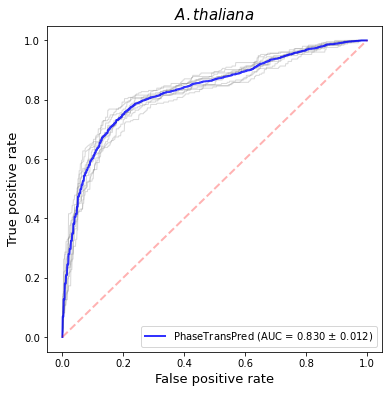

In [26]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fpr = np.linspace(0, 1, 1000)
for i, tpr in enumerate(tprs_2):
    ax.plot(
    fpr,
    tpr,
    color="gray",
    lw=1,
    alpha=0.3
    )
mean_tpr = np.mean(tprs_2, axis=0)
mean_tpr[-1] = 1.0
mean_auc=mean(rocaucs_2)
std_auc=stdev(rocaucs_2)
ax.plot(
    fpr,
    mean_tpr,
    color="b",
    label=r"Seq2Phase (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.3)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Arabidopsis",
)
ax.set_title("$\it{A. thaliana}$", fontsize=15)
ax.legend(loc="lower right")
ax.set_xlabel("False positive rate", fontsize=13)
ax.set_ylabel("True positive rate", fontsize=13)
plt.savefig("fig5_A_thaliana.pdf")
plt.show()

In [27]:
species="Saccharomyces_cerevisiae"

In [28]:
client_set=set()
others_set=set()
no_homolog_set=set()
for rec in SeqIO.parse("result/drllps_client_clstr_"+species+".fasta", "fasta"):
    client_set.add(rec.id)
for rec in SeqIO.parse("result/drllps_nonllps_clstr_"+species+".fasta", "fasta"):
    others_set.add(rec.id)
for rec in SeqIO.parse("result/"+species_dict[species]+"_no_human_homolog.faa", "fasta"):
    no_homolog_set.add(rec.id)
    
mat=np.load("data/PTT5XLU50_yeast.npy", allow_pickle=True)
mat=mat.item()

list_client_arabi=[]
list_others_arabi=[]
for k in mat.keys():
    if k in others_set:
        if k in no_homolog_set:
            list_others_arabi.append(mat[k])
    elif k in client_set:
        if k in no_homolog_set:
            list_client_arabi.append(mat[k])

In [29]:
print(len(client_set),  len(others_set))
print(len(list_client),  len(list_others))
print(len(list_client_arabi),  len(list_others_arabi))
print(len(under_sampling(list_client,list_others)[0]))
print(len(under_sampling(list_client_arabi,list_others_arabi)[0]))

573 5247
2700 12562
124 2779
5400
248


In [30]:
mean_fpr = np.linspace(0, 1, 1000)
tprs_3=[]
rocaucs_3=[]
praucs_3=[]
mccs_3=[]
for i in range(10):
    x_human, y_human=under_sampling(list_client,list_others)
    x_test, y_test=under_sampling(list_client_arabi,list_others_arabi)

    model=make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=True))
    model.fit(x_human, y_human)
    y_pred=model.predict_proba(x_test)[:,1]
    y_pred_bi=model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc=roc_auc_score(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    mcc=matthews_corrcoef(y_test, y_pred_bi)
    rocaucs_3.append(roc_auc)
    praucs_3.append(pr_auc)
    mccs_3.append(mcc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_3.append(interp_tpr)
    print(i)
print("ROCAUC={:.3f}±{:.3f}, PRAUC={:.3f}±{:.3f}, MCC={:.3f}±{:.3f}".format(mean(rocaucs), stdev(rocaucs), mean(praucs), stdev(praucs), mean(mccs), stdev(mccs)))

0
1
2
3
4
5
6
7
8
9
ROCAUC=0.824±0.063, PRAUC=0.797±0.102, MCC=0.512±0.130


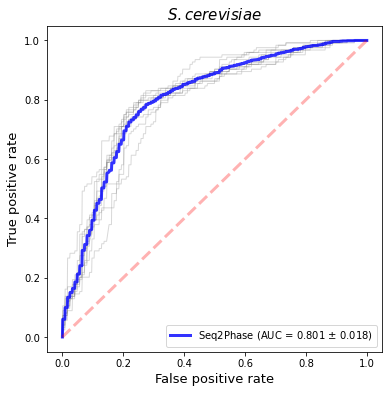

In [31]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fpr = np.linspace(0, 1, 1000)
for i, tpr in enumerate(tprs_3):
    ax.plot(
    fpr,
    tpr,
    color="gray",
    lw=1,
    alpha=0.3
    )
mean_tpr = np.mean(tprs_3, axis=0)
mean_tpr[-1] = 1.0
mean_auc=mean(rocaucs_3)
std_auc=stdev(rocaucs_3)
ax.plot(
    fpr,
    mean_tpr,
    color="b",
    label=r"Seq2Phase (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=3,
    alpha=0.8,
)
ax.plot([0, 1], [0, 1], linestyle="--", lw=3, color="r", alpha=0.3)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Yeast",
)
ax.set_title("$\it{S. cerevisiae}$", fontsize=15)
ax.legend(loc="lower right")
ax.set_xlabel("False positive rate", fontsize=13)
ax.set_ylabel("True positive rate", fontsize=13)
plt.savefig("fig5_S_cerevisiae.pdf")
plt.show()